In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
!pip install torchviz
!pip install hiddenlayer
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=c4e24d141dc8ce322fec5a80522c1233da73d63b20c353d40353110d7932d5d8
  Stored in directory: /root/.cache/pip/wheels/18/0c/ac/81bacd5a53085ac633beb52c80c08152db65a81e93b15b392d
Successfully built torchviz


In [2]:
# Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tarfile
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import time
from torchviz import make_dot
import hiddenlayer as hl

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision import transforms
import torchvision.models as models

project_name='classifying Cancer cell nuclei'
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [171]:
device

device(type='cuda', index=0)

In [4]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()

Image name: 3.png
cells shape: (1,)
First 4 cells: [0]


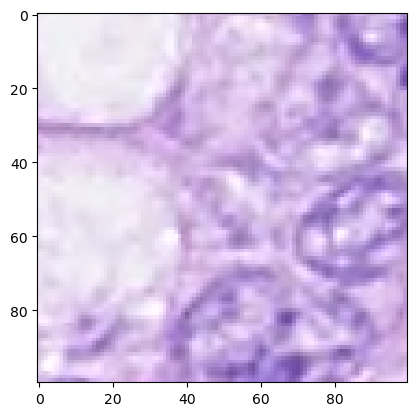

In [5]:
train_csv = pd.read_csv('/kaggle/input/deep-learning-for-msc-2022-23/train.csv')
train_csv.head()

n = 2
img_name = train_csv.iloc[n, 0]
cells = train_csv.iloc[n, 1:]
cells = np.asarray(cells)
# cells = cells.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('cells shape: {}'.format(cells.shape))
print('First 4 cells: {}'.format(cells[:4]))
def show_nucleii(image, label):
    """Show image with landmarks"""
    plt.imshow(image)


plt.figure()
show_nucleii(io.imread(os.path.join('/kaggle/input/deep-learning-for-msc-2022-23/train', img_name)),
               cells)
plt.show()

Custom Dataloader

In [7]:
import torch
import os
from PIL import Image
class NucleiLabels(Dataset):
    """NucleiLabels dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()
        img_name = os.path.join(self.root_dir,self.data.iloc[idx, 0])

        image = Image.open(img_name).convert('RGB')
        label = self.data.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        
        return image,label
#         image = io.imread(img_name)
#         landmarks = self.data.iloc[idx, 1]
# #         label = landmarks
# #         landmarks = landmarks.astype('float').reshape(-1, 2)
#         sample = {'image': image, 'label': landmarks}

#         if self.transform:
#             sample = self.transform(sample)

#         return sample


In [173]:
import datetime
epoch_print_gap = 1

def training_loop(n_epochs, optimizer, model, device, loss_fn, train_loader):
    model = model.to(device)
    train_losses = []
    train_accs = []
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        running_loss = 0.0
        loss_train_l=[]
        running_corrects = 0
        for i, data in enumerate(train_loader,0):
#             print(type(i),' ',type(data))
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
#             inputs, labels = data['image'].float().to(device),data['label'].to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            _, preds = torch.max(outputs, 1)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        loss_train_l.append(loss_train)
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = running_corrects / len(train_loader)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
#         print(train_accs)
        print(' Epoch [%d/%d], Loss: %.4f, Acc: %.4f' % (epoch, n_epochs, epoch_loss, epoch_acc))
    return train_accs,train_losses
#         print('{} Epoch {}, Training loss {}'.format(
#                 datetime.datetime.now(), epoch, float(loss_train)))
    # Plot the loss and accuracy
#     train_accs=[i.cpu().numpy() for i in train_accs]
#     train_accs = (np.rint(train_accs)).astype(int)
#     print(train_accs)
#     return train_losses,train_accs
#     train_accs2=[]
#     for i in train_accs:
#         train_accs2.append(i.cpu().numpy().item())
#     #     print(type(i))
#     # print(train_loss)
#     # print(range(1, n_epochs+1))
#     fig, ax = plt.subplots(1, 2, figsize=(10, 5))
#     ax[0].plot(range(1, n_epochs+1), train_losses, label='Training Loss')
#     ax[0].set_xlabel('Epoch')
#     ax[0].set_ylabel('Loss')
#     ax[0].set_title('Training Loss')
#     ax[0].legend()
#     ax[1].plot(range(1, n_epochs+1), train_accs2, label='Training Acc')
#     ax[1].set_xlabel('Epoch')
#     ax[1].set_ylabel('Accuracy')
#     ax[1].set_title('Training Accuracy')
#     ax[1].legend()
#     plt.show()

def testing_loop(n_epochs, optimizer, model, device, loss_fn, test_loader):
    model = model.to(device)
    train_losses = []
    train_accs = []
#     train_loader = test_loader
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        running_loss = 0.0
        running_corrects = 0
        for i, data in enumerate(test_loader, 0):
            # Get inputs and labels from data loader
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()
            with torch.autograd.set_detect_anomaly(True):
                outputs = torch.clamp(model(inputs),-10,10)
                _, preds = torch.max(outputs, 1)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()
#             loss_train += loss.item() * inputs.size(0)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(test_loader.dataset)
        epoch_acc = running_corrects / len(test_loader.dataset)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        print(' Epoch [%d/%d], Loss: %.4f, Acc: %.4f' % (epoch, n_epochs, epoch_loss, epoch_acc))
    return train_losses,train_accs
    
# def test_loop(model, device, test_loader):
#     model.eval()
#     model = model.to(device)
#     test_loss = 0
#     correct = 0
#     count=0
# #     loss_test_l=[]
#     with torch.no_grad():
#         for i, datai in enumerate(test_loader, 0):
#             data, target = datai
#             data, target = data.to(device), target.to(device)
# #             data, target = data['image'].float().to(device),data['label'].to(device)
#             output = model(data)
#             test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
# #             pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
#             _, pred = torch.max(output.data, 1)
# #             correct += pred.eq(target.view_as(pred)).sum().item()
# #             if(count<=5):
# #                 print('Pred',pred,'\n target',target,'\n',( pred == target))
# #                 count+=1
#             correct += ( pred == target).sum().item()
# #             print('pred',pred)
# #             print(target.view_as(pred))
            
# #         for data, target in test_loader:
# #             data, target = data.to(device), target.to(device)
# #             output = model(data)
# #             test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
# #             pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
# #             correct += pred.eq(target.view_as(pred)).sum().item()

#     test_loss /= len(test_loader.dataset)
# #     loss_test_l.append(test_loss)
# #     print(correct)
# #     print(len(test_loader.dataset))
#     print('Accuracy on the test set: %d %%' % (100 * correct / len(test_loader.dataset)))
# #     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))
# #     return loss_test_l

In [9]:
transformed = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [10]:
transformed_dataset = NucleiLabels(csv_file='/kaggle/input/deep-learning-for-msc-2022-23/train.csv',
                                    root_dir='/kaggle/input/deep-learning-for-msc-2022-23/train',
                                           transform=transformed)

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample[0].shape, sample[1],' of type ',type(sample[1]))

    if i == 3:
        break


0 torch.Size([3, 224, 224]) 0  of type  <class 'numpy.int64'>
1 torch.Size([3, 224, 224]) 0  of type  <class 'numpy.int64'>
2 torch.Size([3, 224, 224]) 0  of type  <class 'numpy.int64'>
3 torch.Size([3, 224, 224]) 0  of type  <class 'numpy.int64'>


In [49]:
# transformed_dataset[0]


In [11]:
import torch
import numpy as np
from torch.utils.data import DataLoader, SubsetRandomSampler
batch_size=4
# set the seed for reproducibility
torch.manual_seed(42)
dataset = transformed_dataset
# Define the indices to split the dataset into train, validation, and test sets
dataset_size = len(dataset)
print(dataset_size)
indices = list(range(dataset_size))
split1 = int(np.floor(0.8 * dataset_size))  # 80% train set
print(split1,len(indices))
# split2 = int(np.floor(0.9 * dataset_size))  # 10% validation set
np.random.shuffle(indices)
# train_indices, val_indices, test_indices = indices[:split1], indices[split1:split2], indices[split2:]
train_indices, test_indices = indices[:split1], indices[split1:]
print(len(train_indices),len(test_indices))

# Define the samplers for each dataset split
train_sampler = SubsetRandomSampler(train_indices)
# val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Define the data loaders for each dataset split
train_loader = DataLoader(dataset, batch_size=batch_size,  sampler=train_sampler)
# val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
print(len(train_loader))
print(len(test_loader))

7560
6048 7560
6048 1512
1512
378


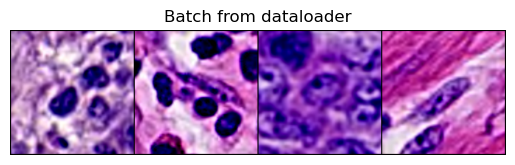

In [12]:


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = sample_batched
#             sample_batched[0], sample_batched['label']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 1

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

#     for i in range(batch_size):
#         plt.scatter(landmarks_batch[i, :, 0].numpy() * grid_border_size,
#             landmarks_batch[i, :, 1].numpy() + grid_border_size,
#             s=10, marker='.', c='r')
#         plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
#                     landmarks_batch[i, :, 1].numpy() + grid_border_size,
#                     s=10, marker='.', c='r')

    plt.title('Batch from dataloader')

# if you are using Windows, uncomment the next line and indent the for loop.
# you might need to go back and change "num_workers" to 0. 

# if __name__ == '__main__':
for i_batch, sample_batched in enumerate(train_loader,0):
#     print(i_batch, sample_batched['image'].size(),
#           sample_batched['label'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv0 = nn.Conv2d(3, 32, kernel_size=(1,1))
        self.relu0 = nn.ReLU()
        
        self.conv1 = nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
        self.flatten = nn.Flatten()
#         self.fc1 = nn.Linear(64*50*50, 128)
        self.fc1 = nn.Linear(64*112*112, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 4)
        self.dropout = nn.Dropout(p=0.6)

    def forward(self, x):
#         print('1',x.shape)
        x = self.conv0(x)
#         print('2',x.shape)
        x = self.relu0(x)
#         print('3',x.shape)
        x = self.conv1(x)
#         print('4',x.shape)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.pool1(x)
#         print('5',x.shape)
        x = self.conv2(x)
#         print('6',x.shape)
        x = self.relu2(x)
#         print('7',x.shape)
        x = self.flatten(x)
#         print('8',x.shape)
        x = self.fc1(x)
#         print('9',x.shape)

        x = self.relu3(x)
#         print('10',x.shape)

        x = self.dropout(x)
        x = self.fc2(x)
        return x



In [174]:
n_epochs = 10 # see how sensitive results are to this
lr = 0.0001
wd = 0.001
model = ConvNet()

device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=lr,weight_decay=wd )

loss_fn = nn.CrossEntropyLoss()

# train the CNN
train_losses,train_accs=training_loop(
    n_epochs = n_epochs, 
    optimizer = optimizer,
    model = model, 
    device = device,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
# Epoch [1/10], Loss: 3.0036, Acc: 2.8710
#  Epoch [2/10], Loss: 2.2308, Acc: 3.1501
#  Epoch [3/10], Loss: 2.0141, Acc: 3.2388
#  Epoch [4/10], Loss: 1.9183, Acc: 3.2731
#  Epoch [5/10], Loss: 1.8038, Acc: 3.3042
#  Epoch [6/10], Loss: 1.7448, Acc: 3.3591
#  Epoch [7/10], Loss: 1.7169, Acc: 3.3545
#  Epoch [8/10], Loss: 1.6593, Acc: 3.3876
#  Epoch [9/10], Loss: 1.6057, Acc: 3.3896
#  Epoch [10/10], Loss: 1.5473, Acc: 3.4239

 Epoch [1/10], Loss: 3.1984, Acc: 2.7811
 Epoch [2/10], Loss: 2.3856, Acc: 3.1270
 Epoch [3/10], Loss: 2.1419, Acc: 3.2004
 Epoch [4/10], Loss: 1.9940, Acc: 3.2321
 Epoch [5/10], Loss: 1.9072, Acc: 3.2685
 Epoch [6/10], Loss: 1.8730, Acc: 3.2956
 Epoch [7/10], Loss: 1.7679, Acc: 3.3413
 Epoch [8/10], Loss: 1.7295, Acc: 3.3638
 Epoch [9/10], Loss: 1.6838, Acc: 3.3724
 Epoch [10/10], Loss: 1.6438, Acc: 3.3962


In [175]:
train_losses,train_accs = train_accs,train_losses

[tensor(2.7811, device='cuda:0'),
 tensor(3.1270, device='cuda:0'),
 tensor(3.2004, device='cuda:0'),
 tensor(3.2321, device='cuda:0'),
 tensor(3.2685, device='cuda:0'),
 tensor(3.2956, device='cuda:0'),
 tensor(3.3413, device='cuda:0'),
 tensor(3.3638, device='cuda:0'),
 tensor(3.3724, device='cuda:0'),
 tensor(3.3962, device='cuda:0')]

In [180]:
train_accs

[3.1983943588676906,
 2.3856044713131808,
 2.1419124207286924,
 1.9940081560989182,
 1.9071924352634049,
 1.8729959724855327,
 1.767869707063905,
 1.7294790773928441,
 1.6838094318641605,
 1.6438200551949973]

In [199]:


test_losses,test_accs = testing_loop1( model, device, loss_fn, test_loader)

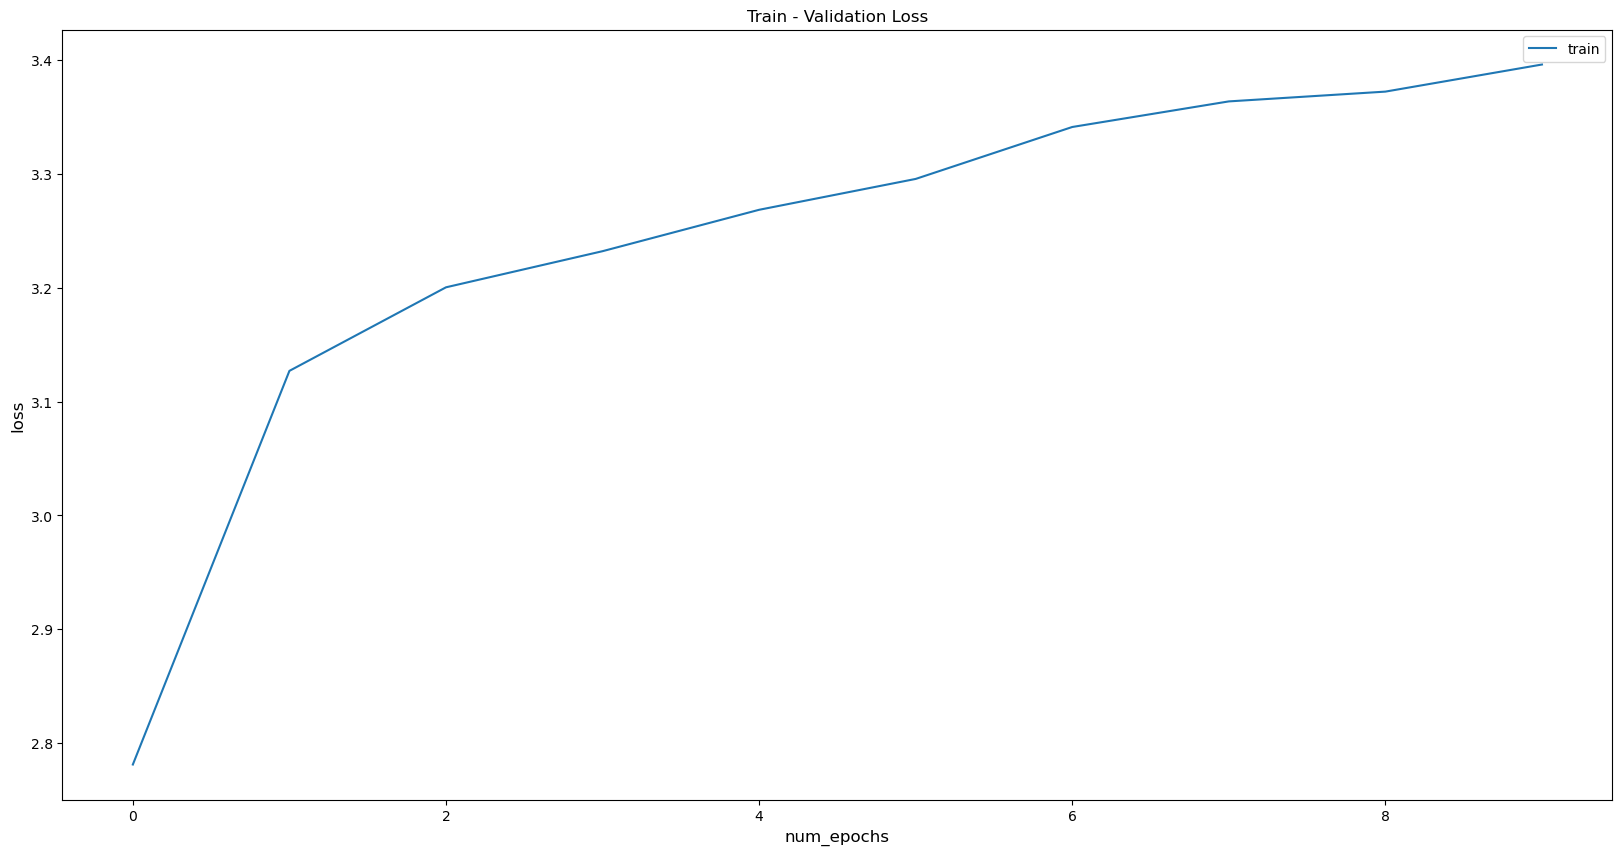

In [200]:
# train_losses=[t.cpu() for t in train_losses]
# test_losses =[t.cpu() for t in test_losses]
# plt.plot( [t.cpu() for t in train_accs], label='train')
# plt.plot( [t.cpu() for t in test_accs], label='validation')
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
# plt.plot( train_losses, label='train')
# plt.plot( test_losses, label='validation')
plt.plot( [t.cpu() for t in train_losses], label='train')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')
plt.show()

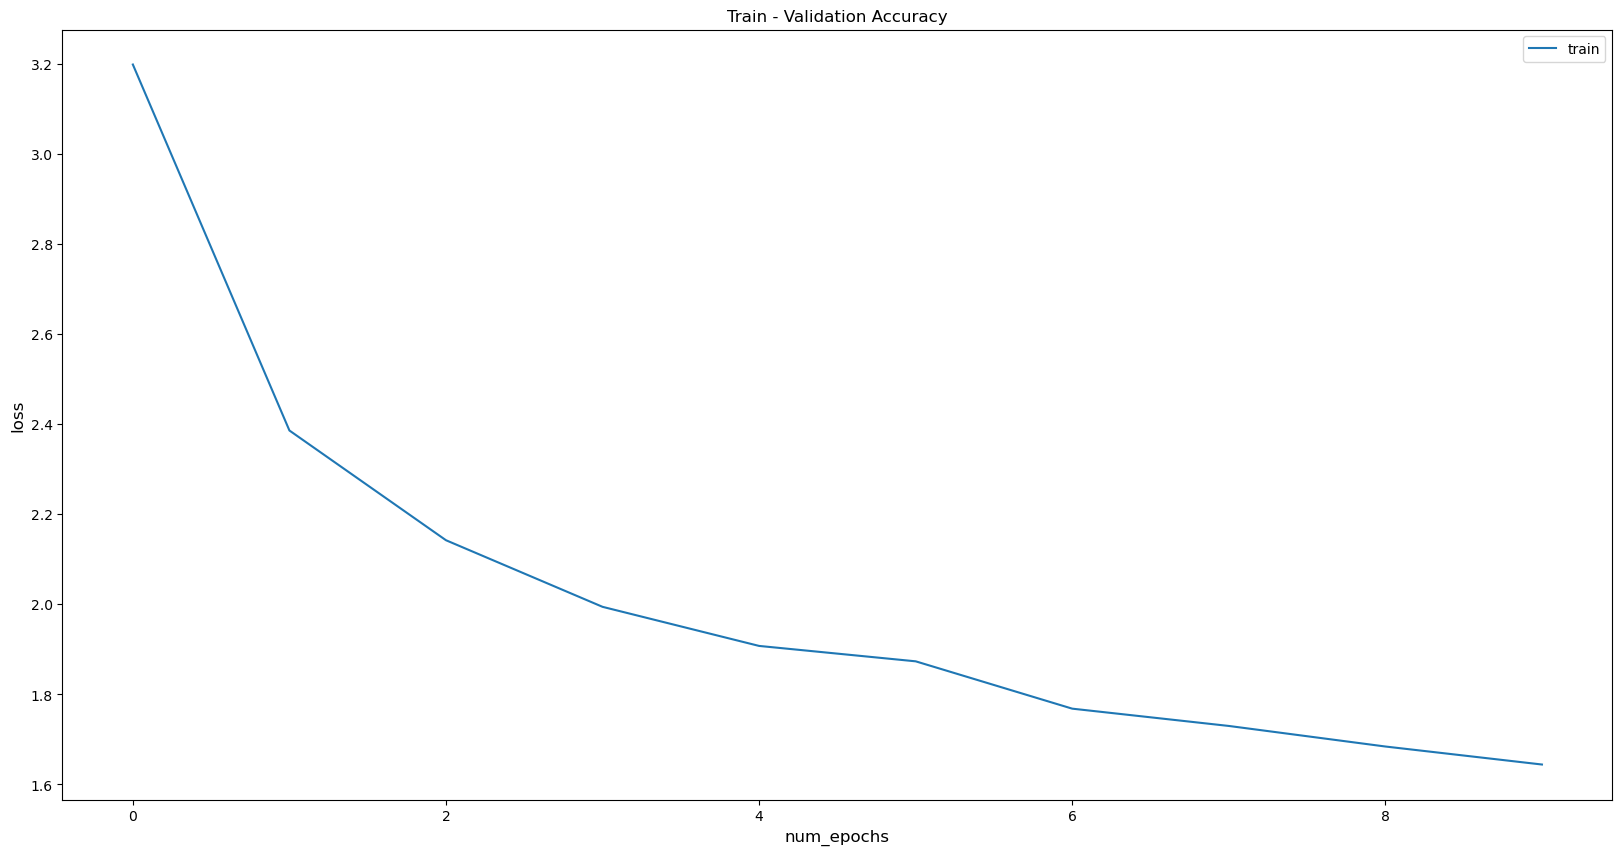

In [201]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
# plt.plot( train_losses, label='train')
# plt.plot( test_losses, label='validation')
plt.plot( train_accs, label='train')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')
plt.show()

[[ 56  69   1   4]
 [ 10 653   6  18]
 [  0   2 134   6]
 [  6  40  29 478]]


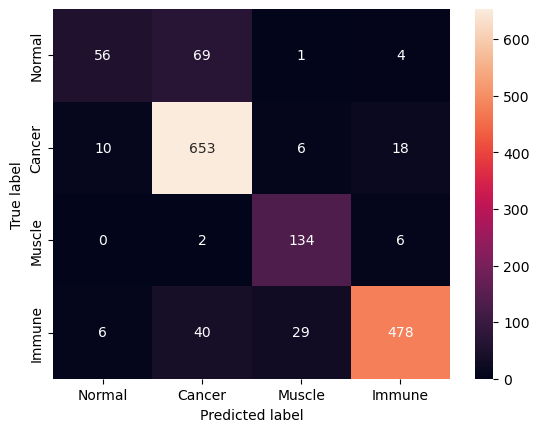

In [30]:
from sklearn.metrics import confusion_matrix
def create_confusion_matrix(model, test_loader, device):
    model.eval()
    model = model.to(device)
    actuals = []
    predictions = []
    with torch.no_grad():
        for i, data1 in enumerate(test_loader,0):
            data, target =data1
            data, target =data.to(device), target.to(device)
#             data, target = data['image'].float().to(device),data['label'].to(device)
#             data, target = sample['image'].to(device), sample['labels'].squeeze(1).to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            actuals += target.tolist()
            predictions += pred.tolist()
    result = confusion_matrix(actuals, predictions)
    return result

confusion_matrix = create_confusion_matrix(model, test_loader, device)
print(confusion_matrix)
# 1. Normal epithelial cell nuclei with label 0.
# 2. Cancer epithelial cell nuclei with label 1.
# 3. Muscle cell nuclei with label 2.
# 4. Immune leukocyte cell nuclei with label 3.
categories=['Normal','Cancer','Muscle','Immune']
import seaborn as sns
sns.heatmap(confusion_matrix, annot=True,fmt='d',xticklabels=categories,yticklabels=categories)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [31]:
model.eval()

# Keep track of the total correct predictions
correct = 0
total = 0

# Disable gradient calculations to speed up inference
with torch.no_grad():
    for i, data1 in enumerate(test_loader,0):
        data, target =data1
        data, target =data.to(device), target.to(device)
#         data, target = data['image'].float().to(device),data['label'].to(device)
        inputs = data
        labels = target
        
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
#         print(labels,predicted)
        correct += ( predicted == labels).sum().item()
print('Accuracy on the test set: %d %%' % (100 * correct / total))

Accuracy on the test set: 86 %


Let's Try Raytune Now

In [14]:
!pip install ray

from functools import partial
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
import torchvision.transforms as transforms
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

class ConvNet_RAY(nn.Module):
    def __init__(self, dropout_rate):
        super(ConvNet_RAY, self).__init__()
        self.conv0 = nn.Conv2d(3, 32, kernel_size=(1,1))
        self.relu0 = nn.ReLU()
        
        self.conv1 = nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1)
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1)
        self.relu2 = nn.ReLU()
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*112*112, 128)
        
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 4)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, x):
#         print(x.shape)
        x = self.conv0(x)
#         print(x.shape)
        x = self.relu0(x)
#         print(x.shape)
        x = self.conv1(x)
#         print(x.shape)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.pool1(x)
#         print(x.shape)
        x = self.conv2(x)
#         print(x.shape)
        x = self.relu2(x)
#         print(x.shape)
        x = self.flatten(x)
#         print(x.shape)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [16]:
def train_nuclei(config, checkpoint_dir=None, data_dir=None):
    print('here1')
    print('config is',config)
    net = ConvNet_RAY(config["dr"])
    print('here1')
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)
    net.to(device)
    print('here1')
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], weight_decay=config["wd"],  momentum=0.9)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)
    print('here1')

    trainloader=train_loader
    valloader = test_loader
    print('here1')
    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels =data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
#                 data, target = data['image'].float().to(device),data['label'].to(device)
                inputs, labels =data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)

        tune.report(loss=(val_loss / val_steps), accuracy=correct / total)
    print("Finished Training")

In [17]:
def test_accuracy(net, device="cpu"):
#     trainset, testset = load_data()
    testloader = test_loader
#     testloader = torch.utils.data.DataLoader(
#         testset, batch_size=4, shuffle=False, num_workers=2)

    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
#         for data in testloader:
            images, labels =data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

In [19]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
    data_dir = os.path.abspath("/kaggle/input/deep-learning-for-msc-2022-23/")
#     load_data(data_dir)
    config = {
    "dr": tune.choice([0.4, 0.6]),
    "wd": tune.loguniform(1e-5, 1e-4),
    "lr": tune.loguniform(1e-5, 1e-4),
    "batch_size": tune.choice([4, 8]),
    "epochs": tune.choice([10, 12])
    }

    
#     config = {
#         "dr": tune.choice([0.2,0.3,0.5]),
# #         "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
#         "lr": tune.loguniform(1e-4, 1e-1),
#         "batch_size": tune.choice([4,8,16,32]),
#                            "epochs" : tune.choice([8,10,12])
#     }
    scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
#     print('here')
    reporter = CLIReporter(
#         parameter_columns=["dr", "lr", "batch_size","epochs"],
        metric_columns=["loss", "accuracy", "training_iteration"])
    result = tune.run(
        partial(train_nuclei,data_dir=data_dir),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter,resume=None)
#     print('here')
    best_trial = result.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(
        best_trial.last_result["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_trial.last_result["accuracy"]))

    best_trained_model = ConvNet_RAY(best_trial.config["dr"])
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if gpus_per_trial > 1:
            best_trained_model = nn.DataParallel(best_trained_model)
    best_trained_model.to(device)

    best_checkpoint_dir = best_trial.checkpoint.dir_or_data
    model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))
    best_trained_model.load_state_dict(model_state)

    test_acc = test_accuracy(best_trained_model, device)
    print("Best trial test set accuracy: {}".format(test_acc))
    return best_trained_model

if __name__ == "__main__":
    # You can change the number of GPUs per trial here:
    best_trained_model = main(num_samples=3, max_num_epochs=10, gpus_per_trial=2)

== Status ==
Current time: 2023-03-27 04:50:35 (running for 00:00:00.19)
Memory usage on this node: 2.9/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_nuclei_2023-03-27_04-50-35
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+--------------------------+----------+------------------+--------------+------+----------+-------------+-------------+
| Trial name               | status   | loc              |   batch_size |   dr |   epochs |          lr |          wd |
|--------------------------+----------+------------------+--------------+------+----------+-------------+-------------|
| train_nuclei_e98e4_00000 | RUNNING  | 172.19.2.2:66036 |            4 |  0.6 |       10 | 6.11327e-05 | 8.15781e-05 |
| train_nuclei_e98e4_00001 | PENDING  |                  |   

== Status ==
Current time: 2023-03-27 04:54:45 (running for 00:04:09.84)
Memory usage on this node: 6.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 8.000: None | Iter 4.000: None | Iter 2.000: None | Iter 1.000: -0.6700911050928491
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_nuclei_2023-03-27_04-50-35
Number of trials: 3/3 (2 PENDING, 1 RUNNING)
+--------------------------+----------+------------------+--------------+------+----------+-------------+-------------+----------+------------+----------------------+
| Trial name               | status   | loc              |   batch_size |   dr |   epochs |          lr |          wd |     loss |   accuracy |   training_iteration |
|--------------------------+----------+------------------+--------------+------+----------+-------------+-------------+----------+------------+----------------------|
| train_nuclei_e98e4_0000

2023-03-27 06:10:43,344	INFO tune.py:763 -- Total run time: 4807.78 seconds (4807.63 seconds for the tuning loop).


== Status ==
Current time: 2023-03-27 06:10:43 (running for 01:20:07.65)
Memory usage on this node: 6.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 8.000: -0.41530188967775006 | Iter 4.000: -0.4828517452090555 | Iter 2.000: -0.5176876178627252 | Iter 1.000: -0.6377243328465041
Resources requested: 0/2 CPUs, 0/2 GPUs, 0.0/7.11 GiB heap, 0.0/3.55 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_nuclei_2023-03-27_04-50-35
Number of trials: 3/3 (3 TERMINATED)
+--------------------------+------------+-------------------+--------------+------+----------+-------------+-------------+----------+------------+----------------------+
| Trial name               | status     | loc               |   batch_size |   dr |   epochs |          lr |          wd |     loss |   accuracy |   training_iteration |
|--------------------------+------------+-------------------+--------------+------+----------+-------------+-------------+----------+------------+------

[[ 64  67   1  13]
 [ 24 595   0  50]
 [  2   6 104  14]
 [  4  19  14 535]]


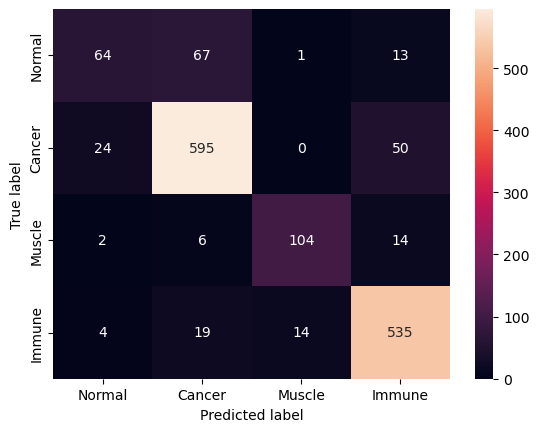

In [20]:
from sklearn.metrics import confusion_matrix
def create_confusion_matrix(model, test_loader, device):
    model.eval()
    model = model.to(device)
    actuals = []
    predictions = []
    with torch.no_grad():
        for i, data1 in enumerate(test_loader,0):
            data, target = data1
            data, target = data.to(device), target.to(device)
#             data, target = sample['image'].to(device), sample['labels'].squeeze(1).to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            actuals += target.tolist()
            predictions += pred.tolist()
    result = confusion_matrix(actuals, predictions)
    return result

confusion_matrix = create_confusion_matrix(best_trained_model, test_loader, device)
print(confusion_matrix)
# 1. Normal epithelial cell nuclei with label 0.
# 2. Cancer epithelial cell nuclei with label 1.
# 3. Muscle cell nuclei with label 2.
# 4. Immune leukocyte cell nuclei with label 3.
categories=['Normal','Cancer','Muscle','Immune']
import seaborn as sns
sns.heatmap(confusion_matrix, annot=True,fmt='d',xticklabels=categories,yticklabels=categories)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [21]:
!pip3 install captum


from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

E0327 06:13:11.754655529      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.6 MB/s eta 0:00:0000:010:01


In [22]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [23]:
ig = IntegratedGradients(best_trained_model)

1
 for Label 1


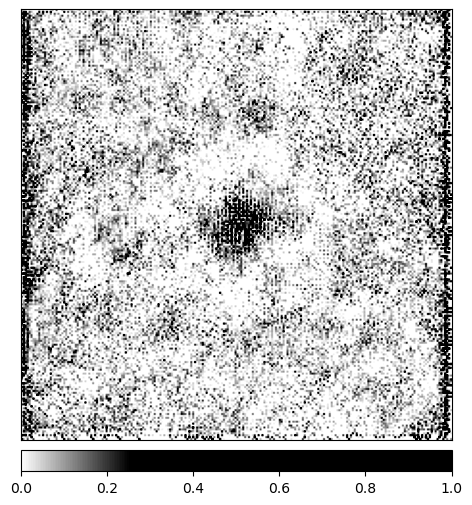

3
 for Label 3


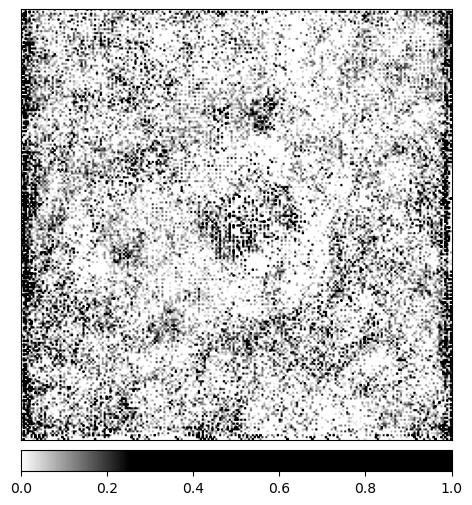

2
 for Label 2


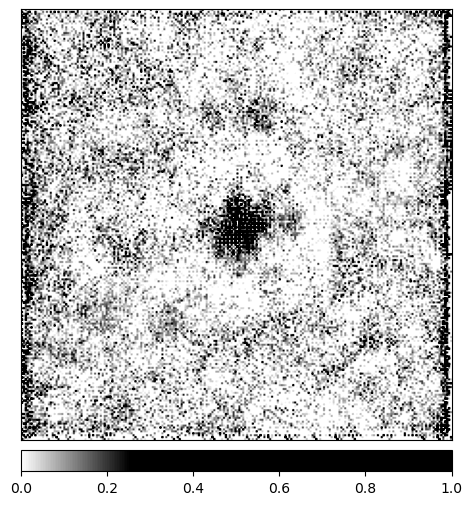

0
 for Label 0


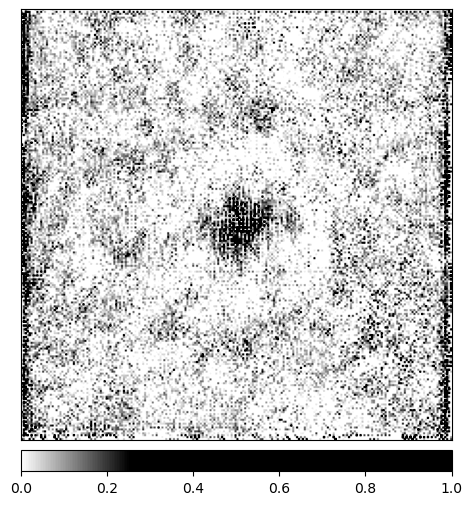

In [218]:
from matplotlib.colors import LinearSegmentedColormap
import torch.nn.functional as F

def vis_captum(input1):
    attr = ig.attribute(input1,target=1)
#     print(attr.shape)
    attr = attr.cpu().detach().numpy()
    default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                     [(0, '#ffffff'),
                                                      (0.25, '#000000'),
                                                      (1, '#000000')], N=256)
    _ = viz.visualize_image_attr(np.transpose(attr.squeeze()),
    np.transpose(input1.squeeze().cpu().detach().numpy()),
                                 method='heat_map',
                                 cmap=default_cmap,
                                 show_colorbar=True,
                                 sign='positive',
                                 outlier_perc=1)
    

count=0
labels_captum=[0,1,2,3]
for i,data in enumerate(test_loader,0):
#     print('high')
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    label_num = labels.cpu().numpy().tolist()
#     print(type(label_num))
    for i in range(len(label_num)):
        
        if(label_num[i] in labels_captum and count<4 ):
#             print(label_num[i])
            print(' for Label',label_num[i])
            count+=1
            labels_captum.remove(label_num[i])
            input1 = inputs[i].unsqueeze(0)
            vis_captum(input1)
            if(len(labels_captum)==0): break
#             print('input1',input1)
            
#     if(count<=2):
#         print()
#         count+=1

tensor(1, device='cuda:0')
torch.Size([1, 3, 224, 224])


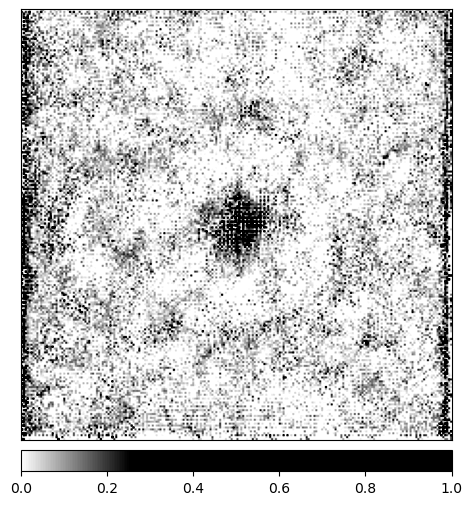

tensor(3, device='cuda:0')
torch.Size([1, 3, 224, 224])


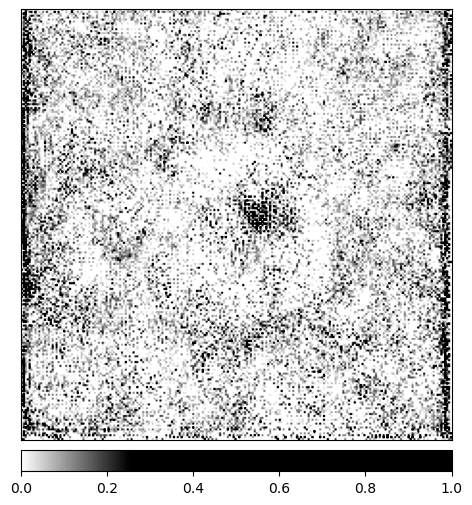

In [219]:
from matplotlib.colors import LinearSegmentedColormap
import torch.nn.functional as F

inputs, labels = data
inputs, labels = inputs.to(device), labels.to(device)

# FOR CELLs :

# Normal epithelial cell nuclei with label 0.

# Cancer epithelial cell nuclei with label 1.

print(labels[3])
input1 = inputs[3].unsqueeze(0)
vis_attr(input1)

# Muscle cell nuclei with label 2.


# Immune leukocyte cell nuclei with label 3.
print(labels[0])
label = labels[0]
input1 = inputs[0].unsqueeze(0)
vis_attr(input1)

# print(input1.shape)
# vis_attr()
# if input1.shape[0]!=3:
#     input1 = input1[:3]
# input1 = torch.unsqueeze(input1, 0)
# input1 = F.interpolate(input1, size=(150, 224, 224))
# input1 = torch.squeeze(input1, 0)
def vis_attr(input1):
    attr = ig.attribute(input1,target=1)
    print(attr.shape)
    attr = attr.cpu().detach().numpy()
    default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                     [(0, '#ffffff'),
                                                      (0.25, '#000000'),
                                                      (1, '#000000')], N=256)
    _ = viz.visualize_image_attr(np.transpose(attr.squeeze()),
    np.transpose(input1.squeeze().cpu().detach().numpy()),
                                 method='heat_map',
                                 cmap=default_cmap,
                                 show_colorbar=True,
                                 sign='positive',
                                 outlier_perc=1)
#         count+=1

In [220]:
# count=0
# for i, data1 in enumerate(test_loader,0):
# #             print(type(i),' ',type(data))
#     if(count<=5):
#         inputs, labels = data1
#         inputs, labels = inputs.to(device), labels.to(device)
# #         inputs, labels = data['image'].float().to(device),data['label'].to(device)
#     #     inputs=inputs.ToTensor()
# #         print(inputs[0])
# #         inputs=inputs[0]
# #         labels=labels[0]
#         attr, delta = ig.attribute(inputs,target=1, return_convergence_delta=True)
#         attr = attr.cpu().detach().numpy()
#         default_cmap = LinearSegmentedColormap.from_list('custom blue', 
#                                                      [(0, '#ffffff'),
#                                                       (0.25, '#000000'),
#                                                       (1, '#000000')], N=256)
# #         print(np.transpose(attr.squeeze()).shape)
# #         print(np.transpose(inputs.squeeze().cpu().detach().numpy()))
#         _ = viz.visualize_image_attr(np.transpose(attr.squeeze()),
#                                  np.transpose(inputs.squeeze().cpu().detach().numpy()),
#                                  method='heat_map',
#                                  cmap=default_cmap,
#                                  show_colorbar=True,
#                                  sign='positive',
#                                  outlier_perc=1)
#         count+=1

In [35]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"



# count=0
# for i, data in enumerate(test_loader,0):
# #             print(type(i),' ',type(data))

#     if(count<=5):
#         inputs, labels = data1
# #         inputs, labels = inputs.to(device), labels.to(device)
# #         inputs=inputs[0]
# #         labels=labels[0]
# #         print(labels[0])
#         output = best_trained_model(inputs)
#         output = F.softmax(output, dim=1)
#         prediction_score, pred_label_idx = torch.topk(output, 1)

#         pred_label_idx.squeeze_()
#     #     inputs=inputs.ToTensor()
#         attr, delta = ig.attribute(inputs,target=1, return_convergence_delta=True)
#         attr = attr.detach().numpy()
#         noise_tunnel = NoiseTunnel(ig)
# #         print(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(),(3,2,0,1)).shape)
# #         print(np.transpose(inputs.squeeze().cpu().detach().numpy()).shape)

#         attributions_ig_nt = noise_tunnel.attribute(inputs, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx)
#         _ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(),(3,2,0,1)),
#                                               np.transpose(inputs.squeeze().cpu().detach().numpy(),(3,2,0,1)),
#                                               ["original_image", "heat_map"],
#                                               ["all", "positive"],
#                                               cmap=default_cmap,
#                                               show_colorbar=True)

In [94]:
# List available models
# all_models = list_models()
# classification_models = list_models(module=torchvision.models)
# classification_models

In [88]:
from torchvision import models
# from captum.attr import IntegratedGradients

import torch.optim as optim
import torch.nn as nn
import torchvision.models as models

class MyCNN_pretained(nn.Module):
    def __init__(self):
        super(MyCNN_pretained, self).__init__()
        self.resnet = models.resnet152(pretrained=True)
#         self.resnet = models.resnet18(pretrained=True)
#         self.resnet = models.efficientnet_v2_l(pretrained=True)
        self.resnet.fc = nn.Linear(2048, 4) # modify the last layer for the new classification task

    def forward(self, x):
        x = self.resnet(x)
        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mycnn = MyCNN_pretained().to(device)
if torch.cuda.is_available() and torch.cuda.device_count()>1:
            mycnn=nn.DataParallel(mycnn)


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mycnn.parameters(), lr=0.0056,weight_decay=0.001)

model = models.resnet152(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

In [89]:
num_epochs = 10
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)

for epoch in range(num_epochs):
    print("Running epoch",epoch+1)
    running_loss = 0.0
    correct = 0
    total=0
    for i, data in enumerate(train_loader, 0):
        # Get inputs and labels from data loader
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass, backward pass, and optimize
        outputs = mycnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # Print statistics
        running_loss += loss.item()
        total += labels.size(0)
#         print(total)
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==labels).item()
    print('Epoch [%d], loss: %.3f' % (epoch+1, running_loss / len(train_loader)))
    print('Epoch %d finished' % (epoch+1))
    print('correct',correct)
    print('total',total)
    print('running_loss',running_loss)
    print('total_step',total_step)
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
#     Running epoch 1
# Epoch [1], loss: 0.894
# Epoch 1 finished
# Running epoch 2
# Epoch [2], loss: 0.757
# Epoch 2 finished
# Running epoch 3
# Epoch [3], loss: 0.710
# Epoch 3 finished
# Running epoch 4
# Epoch [4], loss: 0.674
# Epoch 4 finished
# Running epoch 5
# Epoch [5], loss: 0.633
# Epoch 5 finished
# Running epoch 6
# Epoch [6], loss: 0.624
# Epoch 6 finished
# Running epoch 7
# Epoch [7], loss: 0.594
# Epoch 7 finished
# Running epoch 8
# Epoch [8], loss: 0.588
# Epoch 8 finished
# Running epoch 9
# Epoch [9], loss: 0.560
# Epoch 9 finished
# Running epoch 10
# Epoch [10], loss: 0.546
# Epoch 10 finished

Running epoch 1
Epoch [1], loss: 0.827
Epoch 1 finished
correct 4088
total 6048
running_loss 1249.7856740169227
total_step 1512
Running epoch 2
Epoch [2], loss: 0.461
Epoch 2 finished
correct 5078
total 6048
running_loss 696.834311732091
total_step 1512
Running epoch 3
Epoch [3], loss: 0.323
Epoch 3 finished
correct 5417
total 6048
running_loss 488.92112467298284
total_step 1512
Running epoch 4
Epoch [4], loss: 0.255
Epoch 4 finished
correct 5562
total 6048
running_loss 385.8218578582164
total_step 1512
Running epoch 5
Epoch [5], loss: 0.191
Epoch 5 finished
correct 5696
total 6048
running_loss 288.14834385964787
total_step 1512
Running epoch 6
Epoch [6], loss: 0.189
Epoch 6 finished
correct 5695
total 6048
running_loss 285.5853800739278
total_step 1512
Running epoch 7
Epoch [7], loss: 0.150
Epoch 7 finished
correct 5760
total 6048
running_loss 227.14015798881883
total_step 1512
Running epoch 8
Epoch [8], loss: 0.126
Epoch 8 finished
correct 5816
total 6048
running_loss 190.51654114626

In [74]:

#     batch_loss = 0
#     total_t=0
#     correct_t=0
#     with torch.no_grad():
#         model.eval()
#         for data_t, target_t in (validation_loader):
#             #data_t, target_t = data_t.to(device), target_t.to(device)# on GPU
#             outputs_t = model(data_t)
#             loss_t = criterion(outputs_t, target_t)
#             batch_loss += loss_t.item()
#             _,pred_t = torch.max(outputs_t, dim=1)
#             correct_t += torch.sum(pred_t==target_t).item()
#             total_t += target_t.size(0)
#         val_acc.append(100 * correct_t / total_t)
#         val_loss.append(batch_loss/len(validation_loader))
#         network_learned = batch_loss < valid_loss_min
#         print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
# val_loss

In [90]:
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
batch_loss = 0
total_t=0
correct_t=0
# Set the model to evaluation mode
mycnn.eval()

# Keep track of the total correct predictions
# correct = 0
# total = 0

# Disable gradient calculations to speed up inference
with torch.no_grad():
    # Iterate over the test data
    for data in test_loader:
        # Get inputs and labels from data loader
        inputs, labels = data
        # Move inputs and labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Make predictions
        outputs = mycnn(inputs)
        loss_t = criterion(outputs, labels)
        batch_loss += loss_t.item()
        # Get the predicted class
        _, predicted = torch.max(outputs.data, 1)
        # Update total and correct counts
        total_t += labels.size(0)
        correct_t += (predicted == labels).sum().item()
        val_loss.append(batch_loss/len(test_loader))
    val_acc.append(100 * correct_t / total_t)
# Print the accuracy on the test set
print('Accuracy on the test set: %d %%' % (100 * correct / total))

Accuracy on the test set: 96 %


In [117]:
class submission_class(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
    #     self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.img_list = os.listdir(root_dir)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
    #         if torch.is_tensor(idx):
    #             idx = idx.tolist()
        img_name = os.path.join(self.root_dir, self.img_list[idx])

        image = Image.open(img_name).convert('RGB')
    #     label = self.data.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)

        return image,img_name


        
        
        
transformed = transforms.Compose([
transforms.Resize(256),
transforms.RandomCrop(224),
# transforms.RandomHorizontalFlip(),
transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        
        
        
        
submission_dataset = submission_class(root_dir='/kaggle/input/deep-learning-for-msc-2022-23/test',
                                   transform=transformed)

for i in range(len(submission_dataset)):
    sample = submission_dataset[i]

    print(i, sample[0].shape, sample[1],' of type ',type(sample[1]))

    if i == 3:
        break
example_loader = DataLoader(submission_dataset, batch_size=4)


0 torch.Size([3, 224, 224]) /kaggle/input/deep-learning-for-msc-2022-23/test/14127.png  of type  <class 'str'>
1 torch.Size([3, 224, 224]) /kaggle/input/deep-learning-for-msc-2022-23/test/11396.png  of type  <class 'str'>
2 torch.Size([3, 224, 224]) /kaggle/input/deep-learning-for-msc-2022-23/test/14260.png  of type  <class 'str'>
3 torch.Size([3, 224, 224]) /kaggle/input/deep-learning-for-msc-2022-23/test/12329.png  of type  <class 'str'>


<Figure size 640x480 with 0 Axes>

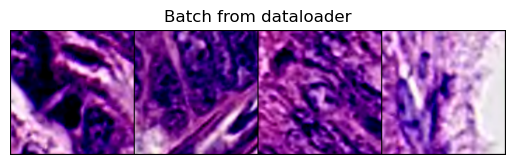

In [119]:

def show_examples_batch2(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch = sample_batched
#     print(images_batch)
#     images_batch=images_batch
#             sample_batched[0], sample_batched['label']
    batch_size = len(images_batch)
#     im_size = images_batch.size(2)
    grid_border_size = 1

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.title('Batch from dataloader')


for i_batch, sample_batched in enumerate(example_loader,0):
#     print(type(sample_batched))
    # observe 4th batch and stop.
    image,name=sample_batched
    if i_batch == 3:
        plt.figure()
        show_examples_batch2(image)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [159]:
count=0
sbmission_pf = pd.DataFrame()
for i_batch, sample_batched in enumerate(example_loader,0):
#     print(type(sample_batched))
    # observe 4th batch and stop.
    image,name=sample_batched
#     image,name=image.to(device),name.to(device)
#     image= data1.to(device)
#     if(count<=2):
#         print(name)
    outputs = mycnn(image)
    # Get the predicted class
    _, predicted = torch.max(outputs.data, 1)
    predicted=predicted.cpu().numpy()
#         print(predicted)
    for i in range(len(name)):
#             print(name[i].split('/')[-1])
        name1=name[i].split('/')[-1]
#             print(predicted[i])
        sbmission_pf=sbmission_pf.append(pd.Series([str(name1),int(predicted[i])]) , ignore_index=True)
#         print(name.split('/')[-1])
#         count+=1
# sbmission_pf.columns = ['Image', 'Label']



In [165]:
sbmission_pf.columns = ['Image', 'Label']

sbmission_pf['Label'] = sbmission_pf['Label'].astype(int)
sbmission_pf.shape


(5041, 2)

In [167]:
sbmission_pf.to_csv('/kaggle/working/submission.csv')

Confusion matrix for RessNet150 model

[[138   4   0   3]
 [  2 655  10   2]
 [  0   0 125   1]
 [  5   8  21 538]]


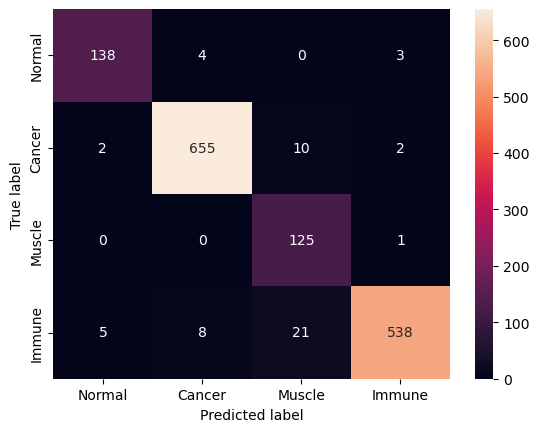

In [168]:
from sklearn.metrics import confusion_matrix
def create_confusion_matrix(model, test_loader, device):
    model.eval()
    model = model.to(device)
    actuals = []
    predictions = []
    with torch.no_grad():
        for i, data1 in enumerate(test_loader,0):
            data, target = data1
            data, target = data.to(device), target.to(device)
#             data, target = sample['image'].to(device), sample['labels'].squeeze(1).to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            actuals += target.tolist()
            predictions += pred.tolist()
    result = confusion_matrix(actuals, predictions)
    return result

confusion_matrix = create_confusion_matrix(mycnn, test_loader, device)
print(confusion_matrix)
# 1. Normal epithelial cell nuclei with label 0.
# 2. Cancer epithelial cell nuclei with label 1.
# 3. Muscle cell nuclei with label 2.
# 4. Immune leukocyte cell nuclei with label 3.
categories=['Normal','Cancer','Muscle','Immune']
import seaborn as sns
sns.heatmap(confusion_matrix, annot=True,fmt='d',xticklabels=categories,yticklabels=categories)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()